# Customer Query Classification
### Hoori Javadnia & Fatemeh Khosravi

### Exploratory Data Analysis

In [ ]:
#!pip install --upgrade emoji
#!pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.3/356.3 kB 5.0 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.5.1-py2.py3-none-any.whl size=351210 sha256=5614fe176293f08405987f0c276b4d77203c41e1bf7bba4e33b950cec1bdcf3b
  Stored in directory: /Users/fatemehkhosravi/Library/Caches/pip/wheels/8d/f5/02/63dc849dcc2c6d417626fd8440f2fc9da91c2f12afbe65c790
Successfully built emoji
  Attempting uninstall: emoji
    Found existing installation: emoji 2.2.0
    Uninstalling emoji-2.2.0:
      Successfully uninstalled emoji-2.2.0
Note: you may need to restart the kernel to use updated packages.


In [24]:
import pandas as pd
import numpy as np
import requests
import time
import random
from collections import OrderedDict
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px
import nltk
import random
py.init_notebook_mode(connected=True)
from nltk.stem import WordNetLemmatizer
from random import randint
#from textblob import TextBlob
from time import sleep
color = sns.color_palette()
%matplotlib inline
from collections import Counter, defaultdict
from string import punctuation
from nltk.corpus import stopwords
from nltk.metrics import ConfusionMatrix
import plotly.io as pio
from nltk.tokenize import word_tokenize
import re
re.compile('<title>(.*)</title>')
import nltk
import os
import re
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
#sw = stopwords.words("english")
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
sw = set(stopwords.words('english'))

### Read the Data

In [2]:
#Read the data

customer_queries = pd.read_csv('customer_query.csv')

### Dimension

The dataset consists of 40,267 samples (queries) with response variable in the 'Class' Column.

In [3]:
#Dimension of the data set

print(customer_queries.shape)

#10 samples from data set

customer_queries.sample(10)

(40267, 2)


,Query,Class
16914,\r\n\r\nMy product shipped months ago but I st...,Product Inquiry
29482,\r\n\r\nHow can I turn on the Bold Text option...,Tech. Support
29343,\r\n\r\n\r\nMy printer won't connect to my hom...,Tech. Support
8498,\r\n\r\nCan you please provide more info about...,Billing
22505,\r\n\r\nI'm trying to set up my wireless print...,Tech. Support
21468,\r\n\r\nI was looking at the specifications fo...,Product Inquiry
796,\r\n\r\nWhat type of surface is this juicer re...,Product Inquiry
15558,"\r\n\r\n""My laptop screen keeps flickering and...",Tech. Support
7122,"\r\n\r\n""How do I reset my cached iTunes passw...",Tech. Support
35312,\r\n\r\nHow do I delete media files off my ext...,Tech. Support


### Check the Balance

Data set has 4 different classes: ‘Billing', 'Product Inquiry, 'Return' and 'Tech. Support’. According to the barplot, the dataset is balanced.

In [4]:
# Check different classes of the response variable

customer_queries['Class'].value_counts()

Class
Billing            10069
Product Inquiry    10067
Returns            10066
Tech. Support      10065
Name: count, dtype: int64

<AxesSubplot:title={'center':"' Barplot of the Class Values'"}, xlabel='Class'>

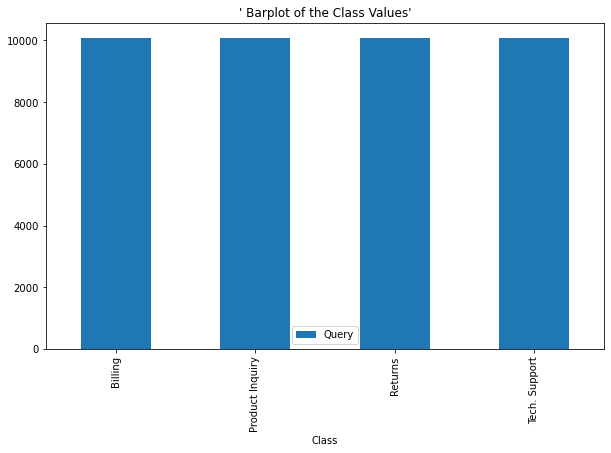

In [5]:
# Barplot of the 'Class' values

customer_queries.groupby('Class').agg({'Query': 'count'}).plot.bar(figsize=(10,6),
                                    title="' Barplot of the Class Values'")

### Clean the Data

In [6]:
# Some punctuation variations

punctuation = set(punctuation) #Creates a set of punctuation marks for later use.


# Stopwords
#Loads a list of stopwords for the English language.

sw = stopwords.words("english")


# useful regex
#Compiles a regular expression pattern to match whitespace.
whitespace_pattern = re.compile(r"\s+")


#Descriptive function
#This function takes a list of tokens as input and calculates various statistics
#such as the total number of tokens, the number of unique tokens, the number of characters, 
#and the lexical diversity. It also prints the top num_tokens most common tokens if specified.


def descriptive_stats(tokens, num_tokens = 10, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens,
        number of characters, lexical diversity, and num_tokens most common
        tokens. Return a list of
    """

    if verbose :
        print(f"There are {len(tokens)} tokens in the data.")
        print(f"There are {len(set(tokens))} unique tokens in the data.")
        print(f"There are {len(''.join(tokens))} characters in the data.")
        print(f"The lexical diversity is {len(set(tokens))/len(tokens):.3f} in the data.")

        counts = Counter(tokens)

        if num_tokens > 0 :
            print("The top ten most common tokens are:")
            top_tokens=counts.most_common(num_tokens)
            top_token_df = pd.DataFrame(top_tokens, columns = ["Token", "Frequency"])
            print(top_token_df)

    return([len(tokens),
           len(set(tokens)),
           len("".join(tokens)),
           len(set(tokens))/len(tokens)])





# Remove stop words  from a list of tokens

def remove_stop(tokens) :
    return([t for t in tokens if t.lower() not in sw])

# Remove punctuation

#Removes punctuation marks from a given text.
def remove_punctuation(text, punct_set=punctuation) :
    return("".join([ch for ch in text if ch not in punct_set]))

#Remove white space
#Replaces multiple consecutive whitespace characters with a single space
def remove_whitespace(text):
    text = whitespace_pattern.sub(r" ", text)
    return text

# Tokenization
#Splits a given text into tokens using whitespace as the delimiter
def tokenize(text) :
    """ Splitting on whitespace rather than the book's tokenize function. That
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """

    return([t for t in whitespace_pattern.split(text) if t])

# pipeline function

#Takes a text and a list of transformation functions as input. 
#It applies each function in the pipeline to the text sequentially, 
#modifying the text along the way.


def prepare(text, pipeline) :
    tokens = str(text)

    for transform in pipeline :
        tokens = transform(tokens)

    return(tokens)



#Overall,this code provides a set of utility functions for text preprocessing and 
#descriptive analysis. It can be used to clean and analyze text data by applying various 
#transformations and computing statistics on the processed text.

In [7]:
# Apply processing pipeline




#processing pipeline that consists of a sequence of functions to be applied to the text data.
#The functions in the pipeline are str.lower (converts text to lowercase),
#remove_punctuation (removes punctuation marks), remove_whitespace (replaces multiple consecutive whitespace characters with a single space), 
#tokenize (splits text into tokens), and remove_stop (removes stopwords).

prep_pipeline = [str.lower, remove_punctuation,remove_whitespace, tokenize, remove_stop]

# Tokenization on 'Query' column
#The prepare function takes the text and the pipeline as inputs, applies each transformation function in the pipeline sequentially, and returns the resulting tokens. The tokens are assigned to a new column named "tokens" in the DataFrame.


customer_queries["tokens"] = customer_queries["Query"].apply(prepare, pipeline = prep_pipeline)

# Count number of tokens in each row

customer_queries["num_tokens"] = customer_queries["tokens"].map(len)

customer_queries.sample(10)


,Query,Class,tokens,num_tokens
34925,\r\n\r\nHow can I return a product I purchased...,Returns,"[return, product, purchased, store]",4
34755,\r\n\r\nWhat is your return policy? Could I ge...,Returns,"[return, policy, could, get, refund, item, im,...",8
16903,\r\n\r\nIs this product suitable for outdoor u...,Product Inquiry,"[product, suitable, outdoor, use, heavy, rain]",6
31526,\r\n\r\nWhat is the tax and grand total for my...,Billing,"[tax, grand, total, order, today]",5
8225,\r\n\r\nMy laptop freezes every time I open a ...,Tech. Support,"[laptop, freezes, every, time, open, new, prog...",10
1243,\r\n\r\nHow do I return a defective tablet?,Returns,"[return, defective, tablet]",3
20442,\r\n\r\nThis request is regarding the charges ...,Billing,"[request, regarding, charges, bill, june, 28th...",16
35730,\r\n\r\nMy computer running unusually slow and...,Tech. Support,"[computer, running, unusually, slow, multiple,...",7
34719,\r\n\r\nCould you provide more information on ...,Returns,"[could, provide, information, customer, return...",10
32821,\r\nQUESTION: Does your bike come ready to rid...,Product Inquiry,"[question, bike, come, ready, ride, various, p...",10


### Descriptive Statistics

Descriptive statistics output is displayed in the code snippet below.
'return', 'product', 'item', 'purchased' and 'payment' are the top ten most common tokens in this dataset.

In [8]:
# We need to transform the Query to lists of tokens for descriptive statistics

tokens_list = customer_queries['tokens'].to_list()

# convert nested list to a flat list

tokens_list  = [item for sublist in tokens_list  for item in sublist]

In [9]:
print("Descriptive Stats:\n")

print(descriptive_stats(tokens_list ))


Descriptive Stats:

There are 364359 tokens in the data.
There are 20993 unique tokens in the data.
There are 2295191 characters in the data.
The lexical diversity is 0.058 in the data.
The top ten most common tokens are:
       Token  Frequency
0     return       8343
1    product       6413
2       item       5398
3  purchased       4106
4    payment       3736
5   recently       3689
6      order       3281
7     please       3227
8         im       3200
9       need       3171
[364359, 20993, 2295191, 0.057616252103008296]


### Query Lengths

Here we can see the distribution histogram of lengths of queries ( number of tokens ) based on its class.
* According to this plot ‘Billing’ and ‘Returns’ categories have the highest number of tokens in the query (38 and 35 tokens, respectively).
* The average number of tokens for all classes is about 10 tokens.  

Class
Billing            AxesSubplot(0.125,0.125;0.775x0.755)
Product Inquiry    AxesSubplot(0.125,0.125;0.775x0.755)
Returns            AxesSubplot(0.125,0.125;0.775x0.755)
Tech. Support      AxesSubplot(0.125,0.125;0.775x0.755)
Name: num_tokens, dtype: object

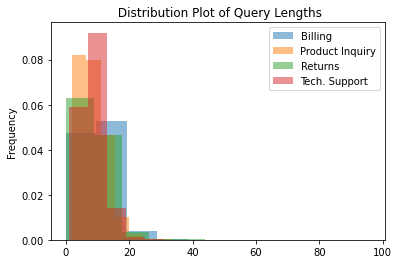

In [10]:
customer_queries.groupby('Class')['num_tokens'].plot(kind="hist",density=True,alpha=0.5,
                         legend=True, title= " Distribution Plot of Query Lengths")

### Descriptive Statistics of Each Class

* Lexical diversity for 'Product Inquiry' class is about 0.127 and for 'Billing' and 'Tech. Support' classes is about 0.078. The lowest lexical diversity belongs to the 'Return' class with 0.065. Higher value means that the queries contain many different word types while lower value of lexical diversity refers to the repeated words or phrases.

* By removing punctuation in the way we did, a number of pairs of stopwords (e.g., "I am" and "is not") show up in the top 10 tokens.

In [11]:
# Billing

billing_query= customer_queries.loc[customer_queries['Class']== 'Billing'].tokens.to_list()
billing_query = [item for sublist in billing_query for item in sublist]


#Product Inquiry
## Extracting the tokens from customer queries that belong to the 'Billing' class
product_query = customer_queries.loc[customer_queries['Class']== 'Product Inquiry'].tokens.to_list()
product_query = [item for sublist in product_query for item in sublist]


# Returns

return_query= customer_queries.loc[customer_queries['Class']== 'Returns'].tokens.to_list()
return_query= [item for sublist in return_query for item in sublist]


#Tech.Support

tech_query = customer_queries.loc[customer_queries['Class']== 'Tech. Support'].tokens.to_list()
tech_query = [item for sublist in tech_query for item in sublist]

In [12]:
# Descriptive Statistics of Billing Class

print("Descriptive Statistics of Billing Class:\n")

print(descriptive_stats(billing_query, num_tokens=10 ))


Descriptive Statistics of Billing Class:

There are 108398 tokens in the data.
There are 8470 unique tokens in the data.
There are 683268 characters in the data.
The lexical diversity is 0.078 in the data.
The top ten most common tokens are:
       Token  Frequency
0    payment       3642
1     please       2288
2    billing       2269
3       bill       1710
4      order       1640
5    invoice       1568
6    account       1225
7   purchase       1117
8       card       1090
9  statement       1078
[108398, 8470, 683268, 0.07813797302533257]


In [13]:
# Descriptive Statistics of Product Inquiry Class

print("Descriptive Statistics of Product Inquiry Class:\n")

print(descriptive_stats(product_query, num_tokens=10 ))


Descriptive Statistics of Product Inquiry Class:

There are 86000 tokens in the data.
There are 10881 unique tokens in the data.
There are 552211 characters in the data.
The lexical diversity is 0.127 in the data.
The top ten most common tokens are:
       Token  Frequency
0    product       4381
1         im       1328
2  available        731
3       come        692
4       size        679
5        use        644
6   products        595
7    looking        587
8   warranty        571
9       type        567
[86000, 10881, 552211, 0.1265232558139535]


In [14]:
# Descriptive Statistics of Return Class

print("Descriptive Statistics of Return Class:\n")

print(descriptive_stats(return_query, num_tokens=10 ))


Descriptive Statistics of Return Class:

There are 88127 tokens in the data.
There are 5765 unique tokens in the data.
There are 556304 characters in the data.
The lexical diversity is 0.065 in the data.
The top ten most common tokens are:
       Token  Frequency
0     return       8042
1       item       4785
2  purchased       3227
3   recently       2291
4     refund       1961
5    product       1809
6    process       1729
7     policy       1563
8  returning       1336
9       need       1310
[88127, 5765, 556304, 0.06541695507619685]


In [15]:
# Descriptive Statistics of Tech. Support Class

print("Descriptive Statistics of Tech. Support Class:\n")

print(descriptive_stats(tech_query, num_tokens=10 ))

Descriptive Statistics of Tech. Support Class:

There are 81834 tokens in the data.
There are 6363 unique tokens in the data.
There are 503408 characters in the data.
The lexical diversity is 0.078 in the data.
The top ten most common tokens are:
      Token  Frequency
0    laptop       2343
1  computer       2168
2      wont       1769
3   printer       1443
4     issue       1145
5      wifi       1114
6      isnt       1091
7       fix       1056
8      turn       1030
9        im        992
[81834, 6363, 503408, 0.07775496737297456]


### World Clouds for all Classes

In [16]:
# Define a Function


# This function generates a word cloud based on word frequencies.
# Parameters:
# - word_freq: The word frequencies, either a Pandas Series or a dictionary.
# - title: The title of the word cloud (optional).
# - max_words: The maximum number of words to display in the word cloud (default: 200).
# - stopwords: A list of stopwords to filter out from the word frequencies (optional).




def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400,
                   background_color= "black", colormap="Paired",
                   max_font_size=150, max_words=max_words)

    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items()
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)

    plt.title(title)

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

    
    
 
# This function counts the frequencies of words in a specified column of a DataFrame.
# Parameters:
# - df: The DataFrame to count words from.
# - column: The column name containing the text data (default: 'tokens').
# - preprocess: A function to preprocess the text data (optional).
# - min_freq: The minimum frequency threshold for words to be included in the output (default: 2).
 
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    # Sort the DataFrame by frequency in descending orde
    return freq_df.sort_values('freq', ascending=False)

In [17]:
# word counts for all classes

billing_query_count = count_words(customer_queries[customer_queries['Class']=="Billing"])
product_query_count = count_words(customer_queries[customer_queries['Class']=="Product Inquiry"])
return_query_count = count_words(customer_queries[customer_queries['Class']=="Returns"])
tech_query_count = count_words(customer_queries[customer_queries['Class']=="Tech. Support"])


#The code is performing word counts for different classes of customer queries. 
#Each line filters the customer_queries DataFrame based on a specific class and then calls 
#the count_words function to count the words in the filtered queries.
#The results are stored in separate variables for each class (billing_query_count, product_query_count, return_query_count, tech_query_count).

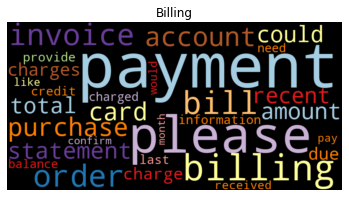

In [18]:
# Billing Class

wordcloud(billing_query_count['freq'], title="Billing", max_words=30, stopwords=None)
# Generate a word cloud for the word frequencies of the "Billing" class

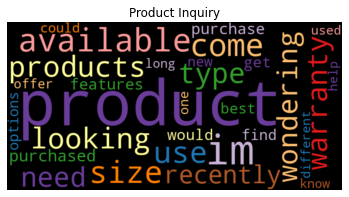

In [19]:
# Product Inquiry Class

wordcloud(product_query_count['freq'], title="Product Inquiry", max_words=30, stopwords=None)
# Generate a word cloud for the word frequencies of the "Product Inquiry" class

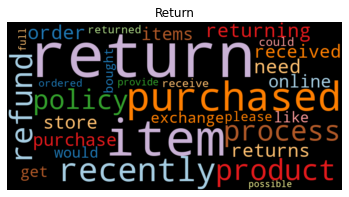

In [20]:
# Return Class
# Generate a word cloud for the word frequencies of the "Return" class
wordcloud(return_query_count['freq'], title="Return", max_words=30, stopwords=None)

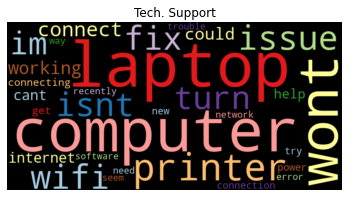

In [21]:
# Tech. Support Class
# Generate a word cloud for the word frequencies of the "Tech. Support" class
wordcloud(tech_query_count['freq'], title="Tech. Support", max_words=30, stopwords=None)

### Save the Clean Data

In [22]:
# Save Clean Data
customer_queries.to_csv('customer_queries_clean.csv', index=False)

## Topic Modeling

### Fitting an LSA Model

In [32]:
#Fitting an LSA Model

# Creating a list of stopwords using the 'sw' variable
stopwords_list = list(sw)
#stopwords_list.extend(["ll", "ve"])


# Creating a TF-IDF vectorizer with the stopwords list.
tfidf_text_vectorizer = TfidfVectorizer(
    stop_words = stopwords_list
)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(customer_queries["Query"].values.astype('U'))
# Checking the shape of the TF-IDF vectors
tfidf_text_vectors.shape


(40267, 18620)

In [33]:
# Initialize an LSA model with 5 components and a random state of 7

lsa_model = TruncatedSVD(n_components = 5, random_state = 7)

# Transform the TF-IDF text vectors using the LSA model to obtain the W matrix
W_lsa_matrix = lsa_model.fit_transform(tfidf_text_vectors)
# Retrieve the LSA model's components to obtain the H matrix
H_lsa_matrix = lsa_model.components_

In [34]:
# Topic index dict 
# (key = topic index) : (value : np.argmax count)
topic_dict = {0 : 0, 1 : 0,
              2 : 0, 3: 0,
              4: 0}

# Iterate over each row in the W_lsa_matrix
for row in W_lsa_matrix:
    # Find most similar topic to document
    topic_idx = np.argmax(row)
    # Add 1 count to topic dictionary
    topic_dict[topic_idx] += 1

topic_dict  # Print or use the topic_dict for further analysis

{0: 10848, 1: 14485, 2: 8302, 3: 918, 4: 5714}

In [36]:


def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()#sum of all the values in the words array, which represents the total occurrence or importance of words in the topic.     
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (
                features[largest[i]], 
                abs(words[largest[i]]*100.0/total)))
            
            
            
#Overall, this code defines a function that takes a topic modeling model,
#a list of features (words), and an optional parameter for the number of top words 
#to display. It then iterates over the topics in the model, calculates 
#the total importance of words in each topic, sorts the words by importance, 
#and prints the top words along with their weights for each topic.            

In [37]:
# call display_topics on your model 

display_topics(lsa_model, tfidf_text_vectorizer.get_feature_names_out())
##This part of the code will display the top words and their weights for each topic in the
#LSA model, using the feature names obtained from the TF-IDF text vectorizer. 



Topic 00
  return (5.93)
  item (4.50)
  purchased (3.51)
  recently (2.17)
  process (1.98)

Topic 01
  payment (1.86)
  please (1.23)
  billing (1.17)
  order (1.10)
  laptop (1.04)

Topic 02
  laptop (13.36)
  computer (11.18)
  turn (10.51)
  printer (9.64)
  connect (9.03)

Topic 03
  product (73.32)
  return (47.68)
  policy (34.86)
  purchase (16.65)
  refund (15.32)

Topic 04
  product (23.35)
  returning (13.39)
  process (8.94)
  purchased (8.80)
  recently (4.58)


### Fitting an LDA Model

In [40]:

count_text_vectorizer = CountVectorizer(
    stop_words = stopwords_list, 
    min_df = 5, 
    max_df = 0.7
)
count_text_vectors = count_text_vectorizer.fit_transform(customer_queries["Query"].values.astype('U'))
# prints the shape of the count_text_vectors matrix
count_text_vectors.shape

#Overall, the code demonstrates the use of CountVectorizer to convert a collection of text 
#documents into a numerical representation.It also sets some parameters to control the
#tokenization process and the inclusion of words in the matrix based on their document 
#frequency.

(40267, 4365)

In [41]:
# Create a LatentDirichletAllocation object
lda_model = LatentDirichletAllocation(n_components = 5, random_state = 7)
# Fit the LDA model to the count_text_vectors and
#transform the data into a topic-document matrix
W_lda_matrix = lda_model.fit_transform(count_text_vectors)
## Retrieve the topic-word matrix from the trained LDA model
H_lda_matrix = lda_model.components_

In [42]:
# Call `display_topics` on your fitted model here
display_topics(lda_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  behavior (3.39)
  billens (3.09)
  267 (2.69)
  266 (2.05)
  12363 (1.95)

Topic 01
  blom (4.56)
  boil (2.08)
  behavior (2.05)
  2294 (2.05)
  comforters (1.63)

Topic 02
  arisen (3.73)
  540 (3.24)
  blind (2.16)
  appriciate (1.95)
  conduct (1.62)

Topic 03
  blom (4.80)
  carries (1.36)
  assitance (1.28)
  administration (0.99)
  4g (0.95)

Topic 04
  burner (9.99)
  appropriated (6.37)
  boiled (4.80)
  bowick (3.48)
  breeze (2.65)
